In [1]:
###### Installing packages ##########
#import sys
#!{sys.executable} -m pip install boostaroota

In [163]:
import numpy as np
import pandas as pd
import re as re
import pickle

from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as st
import scipy.special as spec
import math

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,StratifiedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from math import log

from boostaroota import BoostARoota
from xgboost import XGBClassifier, plot_importance

##########

import warnings
warnings.filterwarnings("ignore")

import nbimporter
from setup_code import *

In [164]:
data = pd.read_csv('nba_shots.csv')
#data.set_index('GAME_ID1', inplace=True)

In [165]:
############################## Creating Variables ##############################

date_game = pd.DataFrame(data['MATCHUP'].str.split('-',1).tolist(), columns = ['GAME_DATE','TEAMS'])
teams = pd.DataFrame(date_game['TEAMS'].str.split('@ | vs.',1).tolist(), columns = ['TEAM1','TEAM2'])
minutes_split = pd.DataFrame(data['GAME_CLOCK'].str.split(':',1).tolist(), columns = ['min', 'sec'])

#GAME_DATE
data['GAME_DATE'] = pd.to_datetime(date_game['GAME_DATE'])

#HOME_TEAM
data.loc[data['LOCATION'] == 'H', 'HOME_TEAM'] = teams['TEAM1']
data.loc[data['LOCATION'] == 'A', 'HOME_TEAM'] = teams['TEAM2']

#AWAY_TEAM
data.loc[data['LOCATION'] == 'H', 'AWAY_TEAM'] = teams['TEAM2']
data.loc[data['LOCATION'] == 'A', 'AWAY_TEAM'] = teams['TEAM1']

#PLAYER_TEAM
data.loc[data['LOCATION'] == 'H', 'PLAYER_TEAM'] = data['HOME_TEAM']
data.loc[data['LOCATION'] == 'A', 'PLAYER_TEAM'] = data['AWAY_TEAM']

#GAME_CLOCK_SEC
data['GAME_CLOCK_SEC'] = pd.to_numeric(minutes_split['min'])*60 + pd.to_numeric(minutes_split['sec'])

#W
data.loc[data['W']=='W','WIN_IND'] = 1
data.loc[data['W']=='L','WIN_IND'] = 0

#THREE_POINTS_SHOT
data.loc[data['PTS_TYPE']== 3,'THREE_POINTS_SHOT'] = 1
data.loc[data['PTS_TYPE']== 2,'THREE_POINTS_SHOT'] = 0

#PLAYER_HOME
data.loc[data['LOCATION'] == 'H', 'PLAYER_HOME'] = 1
data.loc[data['LOCATION'] == 'A', 'PLAYER_HOME'] = 0

#Weekday and Month
data['GAME_WEEKDAY'] = data['GAME_DATE'].dt.weekday
data['GAME_MONTH'] = data['GAME_DATE'].dt.month

In [166]:
############################## Imputing Variables ##############################

#data.isna().sum()
data['SHOT_CLOCK'] = data['SHOT_CLOCK'].fillna(data['GAME_CLOCK_SEC'])

In [167]:
############################## Changing Variables Types ##############################

variables_to_categories = ['PERIOD', 'PTS_TYPE', 'GAME_WEEKDAY', 'GAME_MONTH', 'WIN_IND', 'THREE_POINTS_SHOT', 
                          'PLAYER_HOME']

for variable in variables_to_categories:
    data.loc[:,variable] = data[variable].astype('object')

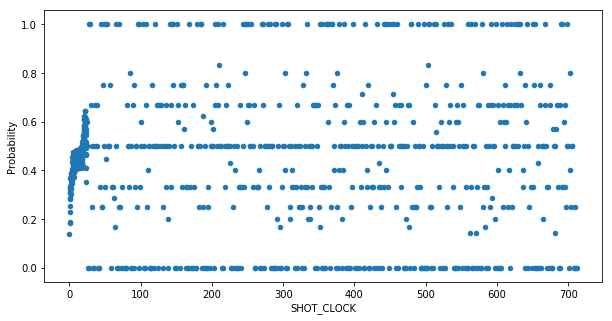

In [178]:
############################## Variables Exploration (Against Response)##############################
variable = 'SHOT_CLOCK'


if data[variable].dtype.kind == 'O':
    plot_type = 'bar'
else:
    plot_type = 'scatter'
    
plot_against_response = data[[variable, 'FGM']].groupby([variable],
                                     as_index=False).mean().sort_values(by = variable, ascending = True)

plot_against_response.rename(index=str, columns={'FGM': 'Probability'}, inplace = True)
plot = plot_against_response.plot(x=variable, y = 'Probability', kind=plot_type, figsize = (10,5))

## Seems not important: SHOT_NUMBER, LOCATION

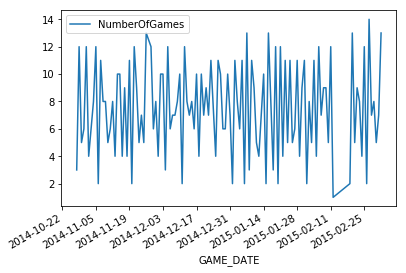

In [169]:
#tmp = data.groupby(['GAME_DATE']).size().reset_index(name ='NumberOfRecords').set_index(['GAME_DATE'])
#plot = tmp.plot()

tmp = data.groupby(['GAME_DATE'])['GAME_ID1'].nunique().reset_index(name ='NumberOfGames').set_index(['GAME_DATE'])
plot = tmp.plot()

In [170]:
#data.to_csv('check.csv', index = False, header = True)
#data.head()

In [171]:
# Per Player, per Game: count how many 2pts/3pts shots they shoot/made
three_points_metrics = data.loc[data['THREE_POINTS_SHOT']==1,:].groupby(['player_id', 'GAME_ID1', 'GAME_DATE', 'WIN_IND','FINAL_MARGIN']).FGM.agg(['sum', 'count']).reset_index()
three_points_metrics.rename(index=str, columns={'sum': 'SuccessfulShots3pts', 'count': 'Shots3pts'}, inplace = True)

two_points_metrics = data.loc[data['THREE_POINTS_SHOT']==0,:].groupby(['player_id', 'GAME_ID1','GAME_DATE', 'WIN_IND', 'FINAL_MARGIN']).FGM.agg(['sum', 'count']).reset_index()
two_points_metrics.rename(index=str, columns={'sum': 'SuccessfulShots2pts', 'count': 'Shots2pts'}, inplace = True)

#merge into one table and replace NAs with 0 shots
player_stats = three_points_metrics.merge(two_points_metrics, on = ['player_id', 'GAME_ID1','GAME_DATE', 'WIN_IND', 'FINAL_MARGIN'], 
                                          how = 'outer')
player_stats.fillna(0, inplace = True)

#sort so that you could search for past N games
player_stats.sort_values(by = ['player_id', 'GAME_DATE'], inplace = True)

#set date as index so you'd have it in your data when you calculate rolling metrics
player_stats.set_index('GAME_DATE', inplace = True)
player_stats.head()

LookAtPastGames = [3,5]
all_history = data.loc[:, ['player_id', 'GAME_DATE']].drop_duplicates()

for PastGames in LookAtPastGames:
    
    #Find Wins and Shots for previous N games
    player_wins = player_stats.groupby('player_id')['WIN_IND'].rolling(PastGames).sum().shift(1).reset_index(name = 'PastGamesPlayerWins')
    player_final_margin = player_stats.groupby('player_id')['FINAL_MARGIN'].rolling(PastGames).sum().shift(1).reset_index(name = 'PastGamesFinalMargin')

    player_shots3pt = player_stats.groupby('player_id')['Shots3pts'].rolling(PastGames).sum().shift(1).reset_index()
    player_shots2pt = player_stats.groupby('player_id')['Shots2pts'].rolling(PastGames).sum().shift(1).reset_index()

    player_success_shots3pt = player_stats.groupby('player_id')['SuccessfulShots3pts'].rolling(PastGames).sum().shift(1).reset_index()
    player_success_shots2pt = player_stats.groupby('player_id')['SuccessfulShots2pts'].rolling(PastGames).sum().shift(1).reset_index()

    #Group all the data together into "player_stats_past_games"
    total_shots = player_shots3pt.merge (player_shots2pt, on = ['player_id', 'GAME_DATE'], how = 'outer')
    success_shots = player_success_shots3pt.merge (player_success_shots2pt, on = ['player_id', 'GAME_DATE'], how = 'outer')
    player_shots = total_shots.merge (success_shots, on = ['player_id', 'GAME_DATE'], how = 'outer')
    
    player_res = player_wins.merge(player_final_margin, on = ['player_id', 'GAME_DATE'], how = 'outer')
    
    player_stats_past_games = player_shots.merge(player_res, on = ['player_id', 'GAME_DATE'], how = 'outer')

    #Calculate ratio metrics
    player_stats_past_games['PastGamePlayerAccuracy2pts'] = player_stats_past_games['SuccessfulShots2pts']/ player_stats_past_games['Shots2pts']
    player_stats_past_games['PastGamePlayerAccuracy3pts'] = player_stats_past_games['SuccessfulShots3pts']/ player_stats_past_games['Shots3pts']

    player_stats_past_games['PastGamesPlayerWinPrcnt'] = player_stats_past_games['PastGamesPlayerWins']/10
    
    columns = list(player_stats_past_games)
    columns.remove('player_id')
    columns.remove('GAME_DATE')
    new_columns = [element+str(PastGames)+'Games' for element in columns]
       
    player_stats_past_games.rename(columns = dict(zip(columns, new_columns)), inplace = True)

    all_history = all_history.merge(player_stats_past_games,on = ['player_id', 'GAME_DATE'], how = 'left')

In [172]:
columns = list(all_history)
columns.remove('player_id')
columns.remove('GAME_DATE')

############## Add Player Stats to the Master Table #############

new_columns_player = ['Player' + element for element in columns]
    
#do not rename "inplace" because you need the originial names in the next steps    
data = data.merge(all_history.rename(columns = dict(zip(columns, new_columns_player))),
                  on = ['player_id', 'GAME_DATE'], how = 'left')

############## Add Defender Stats to the Master Table #############

new_columns_defender = ['Defender' + element for element in columns]
    
all_history.rename(columns = dict(zip(columns, new_columns_defender)), inplace = True)
all_history.rename(columns = {'player_id':'CLOSEST_DEFENDER_PLAYER_ID'}, inplace = True)

data = data.merge(all_history,on = ['CLOSEST_DEFENDER_PLAYER_ID', 'GAME_DATE'], how = 'left')
all_history = pd.DataFrame() #delete just in case 

In [173]:
shots = data.loc[:, ['player_id', 'GAME_DATE', 'SHOT_NUMBER', 'PERIOD']]
shots.merge(data, on = [])

In [145]:
list(data)

['GAME_ID1',
 'MATCHUP',
 'LOCATION',
 'W',
 'FINAL_MARGIN',
 'SHOT_NUMBER',
 'PERIOD',
 'GAME_CLOCK',
 'SHOT_CLOCK',
 'DRIBBLES',
 'TOUCH_TIME',
 'SHOT_DIST',
 'PTS_TYPE',
 'SHOT_RESULT',
 'CLOSEST_DEFENDER_PLAYER_ID',
 'CLOSE_DEF_DIST',
 'FGM',
 'PTS',
 'player_id',
 'GAME_DATE',
 'HOME_TEAM',
 'AWAY_TEAM',
 'PLAYER_TEAM',
 'GAME_CLOCK_SEC',
 'WIN_IND',
 'THREE_POINTS_SHOT',
 'PLAYER_HOME',
 'GAME_WEEKDAY',
 'GAME_MONTH',
 'PlayerShots3pts3Games',
 'PlayerShots2pts3Games',
 'PlayerSuccessfulShots3pts3Games',
 'PlayerSuccessfulShots2pts3Games',
 'PlayerPastGamesPlayerWins3Games',
 'PlayerPastGamesFinalMargin3Games',
 'PlayerPastGamePlayerAccuracy2pts3Games',
 'PlayerPastGamePlayerAccuracy3pts3Games',
 'PlayerPastGamesPlayerWinPrcnt3Games',
 'PlayerShots3pts5Games',
 'PlayerShots2pts5Games',
 'PlayerSuccessfulShots3pts5Games',
 'PlayerSuccessfulShots2pts5Games',
 'PlayerPastGamesPlayerWins5Games',
 'PlayerPastGamesFinalMargin5Games',
 'PlayerPastGamePlayerAccuracy2pts5Games',
 'PlayerP

In [147]:
############################## Delete Variables ##############################

variables_to_delete = [     
                        'MATCHUP',  
                        'LOCATION',
                        'W',  
                        'FINAL_MARGIN', 

                        'GAME_CLOCK',

                        'PTS_TYPE',
                        'SHOT_RESULT', 

                        'PTS', 

                        'GAME_DATE',

    
                        'GAME_ID1',
                        'CLOSEST_DEFENDER_PLAYER_ID',
                        'player_id',
                        'HOME_TEAM',
                        'AWAY_TEAM',
                        'PLAYER_TEAM'
                        ]

for variable in variables_to_delete:
    data = data.drop (variable, 1)

ValueError: labels ['MATCHUP'] not contained in axis

In [134]:
data.to_csv('check.csv', index = False, header = True)

In [148]:
### Delete Rows with NAs
data.dropna(axis = 0, inplace = True)

In [149]:
############################## Creating Dummy Variables ##############################

data = create_dummies(data,0)

In [150]:
y = data.loc[:,'FGM']
X = data.drop ('FGM', 1)

In [151]:
test_prc = 0.3
random = 1992

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = test_prc, random_state = random)

In [152]:
############################## Feature Selection ##############################

# BoostARoota from: https://github.com/chasedehan/BoostARoota# BoostAR 
br = BoostARoota(metric='logloss', silent=True)

br.fit(X_train,y_train)
X_train_reduced = br.transform(X_train)

print("The algorithm reduced the data from " + str(X_train.shape[1]) + " to " + 
      str(X_train_reduced.shape[1]) + " variables")

important_variables = list (X_train_reduced)
#important_variables = list (X_train)
#important_variables

The algorithm reduced the data from 45 to 25 variables


In [153]:
X_train = X_train.loc[:, important_variables]
X_test = X_test.loc[:, important_variables]

In [154]:
print ("Check: \n" + 
       "Training size is " + str(X_train.shape) + "\n" + 
       "Testing size is " + str(X_test.shape) + "\n"
      )

Check: 
Training size is (66411, 25)
Testing size is (28463, 25)



In [155]:
best_classifier = GradientBoostingClassifier()#XGBClassifier()
best_classifier.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [175]:
y_pred = best_classifier.predict(X_test)
y_pred_prob = best_classifier.predict_proba(X_test)

roc = 100*roc_auc_score(y_test, y_pred)
acc = 100*accuracy_score(y_test, y_pred)
ll = log_loss(y_test, y_pred_prob)
acc

62.42138917190739

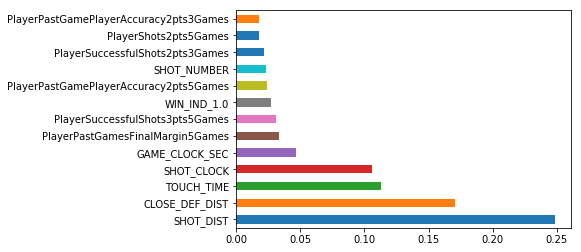

In [161]:
#plot = plot_importance(best_classifier, max_num_features=15)
features_plot = pd.Series(best_classifier.feature_importances_, index=X_test.columns).nlargest(13).plot(kind='barh')